# Content-based Filtering

In [26]:
%pip install pandas -q pandas

import pandas as pd

beers_df = pd.read_csv('D:/Master/FSS_25/Web_Mining/Project/beer_reviews/beers.csv')
beers_df.head()

Note: you may need to restart the kernel to use updated packages.


,id,name,brewery_id,state,country,style,availability,abv,notes,retired
0,202522,Olde Cogitator,2199,CA,US,English Oatmeal Stout,Rotating,7.3,No notes at this time.,f
1,82352,Konrads Stout Russian Imperial Stout,18604,NaN,NO,Russian Imperial Stout,Rotating,10.4,No notes at this time.,f
2,214879,Scottish Right,44306,IN,US,Scottish Ale,Year-round,4.0,No notes at this time.,t
3,320009,MegaMeow Imperial Stout,4378,WA,US,American Imperial Stout,Winter,8.7,Every time this year,f
4,246438,Peaches-N-Cream,44617,PA,US,American Cream Ale,Rotating,5.1,No notes at this time.,f


In [27]:
# Select useful columns
useful_cols = ['id', 'style', 'availability', 'country', 'abv', 'retired']
beers_df = beers_df[useful_cols]

In [28]:
# Drop missing values
beers_df.dropna(subset=['style', 'availability', 'country', 'abv'], inplace=True)

In [29]:
# Filter out abnormal abv values (less than or equal to 0, or greater than 20)
beers_df = beers_df[(beers_df['abv'] > 0) & (beers_df['abv'] < 20)]

In [30]:
# Drop duplicate beer IDs (keep the first one)
beers_df.drop_duplicates(subset='id', inplace=True)

In [31]:
# Force data type conversions
beers_df['abv'] = beers_df['abv'].astype(float)
beers_df['retired'] = beers_df['retired'].astype(str)

In [32]:
# Reset index
beers_df.reset_index(drop=True, inplace=True)

In [33]:
# Stratified sampling: sample up to 50 beers per style
beers_df = (
    beers_df.groupby('style', group_keys=False)
    .apply(lambda x: x.sample(min(len(x), 50), random_state=42))
    .reset_index(drop=True)
)

print("Stratified sampling completed! {} records retained.".format(len(beers_df)))
beers_df.head()

Stratified sampling completed! 5535 records retained.


C:\Users\97\AppData\Local\Temp\ipykernel_1948\3672703020.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), 50), random_state=42))


,id,style,availability,country,abv,retired
0,8704,American Adjunct Lager,Year-round,CO,4.0,f
1,50819,American Adjunct Lager,Year-round,CA,5.0,f
2,3474,American Adjunct Lager,Year-round,US,5.9,f
3,26195,American Adjunct Lager,Year-round,SV,3.7,f
4,36940,American Adjunct Lager,Year-round,US,5.2,f


In [34]:
beers_df.to_csv('D:/Master/FSS_25/Web_Mining/Project/cleaned_beers.csv', index=False)

# Construct feature vectors for each beer

In [35]:
%pip install -q scikit-learn
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import numpy as np

# Define columns
categorical_cols = ['style', 'availability', 'country', 'retired']
numerical_cols = ['abv']

# One-hot encode categorical features
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_encoded = ohe.fit_transform(beers_df[categorical_cols])

# Normalize numerical features
scaler = MinMaxScaler()
numerical_scaled = scaler.fit_transform(beers_df[numerical_cols])

# Combine into final feature matrix
beer_vectors = np.hstack((numerical_scaled, categorical_encoded))

# Store beer ID for later reference
beer_ids = beers_df['id'].values

Note: you may need to restart the kernel to use updated packages.


# Define the recommendation function

In [36]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Create mapping from beer_id to its feature vector
beer_id_to_vector = dict(zip(beer_ids, beer_vectors))

# Recommendation function: return top-N similar beers
def recommend_similar_beers(beer_id, top_n=5):
    if beer_id not in beer_id_to_vector:
        return f"Beer ID {beer_id} not found."

    target_vector = beer_id_to_vector[beer_id].reshape(1, -1)
    similarities = cosine_similarity(target_vector, beer_vectors)[0]

    sim_df = pd.DataFrame({
        'beer_id': beer_ids,
        'similarity': similarities
    })

    sim_df = sim_df[sim_df['beer_id'] != beer_id]
    top_recs = sim_df.sort_values(by='similarity', ascending=False).head(top_n)

    return beers_df[beers_df['id'].isin(top_recs['beer_id'].values)].merge(
    top_recs.rename(columns={'beer_id': 'id'}), on='id'
).sort_values(by='similarity', ascending=False)

# Try a recommendation

In [37]:
# Pick a beer to test
sample_beer_id = beers_df.iloc[0]['id']
print("Recommendations for Beer ID:", sample_beer_id)

# Get similar beers
recommend_similar_beers(sample_beer_id, top_n=10)

Recommendations for Beer ID: 8704


,id,style,availability,country,abv,retired,similarity
1,36940,American Adjunct Lager,Year-round,US,5.2,f,0.753076
9,137557,American Adjunct Lager,Year-round,CA,5.5,f,0.753073
7,62084,American Adjunct Lager,Year-round,US,5.5,f,0.753073
0,50819,American Adjunct Lager,Year-round,CA,5.0,f,0.753054
2,30922,American Adjunct Lager,Year-round,CA,5.0,f,0.753054
6,2549,American Adjunct Lager,Year-round,CA,5.0,f,0.753054
8,6239,American Adjunct Lager,Year-round,US,5.0,f,0.753054
5,261312,American Adjunct Lager,Year-round,CU,4.9,f,0.753035
3,90021,American Adjunct Lager,Year-round,CA,4.9,f,0.753035
4,1849,American Adjunct Lager,Year-round,CA,4.9,f,0.753035


# Top-N Multi-Field Consistency Evaluation

In [38]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def top_n_multi_field_consistency(beer_vectors, beers_df, top_n=5, fields=['style', 'availability', 'country', 'retired']):
    similarity_matrix = cosine_similarity(beer_vectors)
    np.fill_diagonal(similarity_matrix, -1)

    total_counts = {field: 0 for field in fields}
    consistent_counts = {field: 0 for field in fields}

    for i, row in beers_df.iterrows():
        top_indices = similarity_matrix[i].argsort()[-top_n:]
        top_rows = beers_df.iloc[top_indices]

        for field in fields:
            ref_value = row[field]
            top_values = top_rows[field]
            consistent_counts[field] += sum(top_values == ref_value)
            total_counts[field] += top_n

    consistency_scores = {field: consistent_counts[field] / total_counts[field] for field in fields}
    avg_score = np.mean(list(consistency_scores.values()))

    return consistency_scores, avg_score

fields = ['style', 'availability', 'country', 'retired']
scores, avg = top_n_multi_field_consistency(beer_vectors, beers_df, top_n=10, fields=fields)

print("Top-10 Consistency Scores:")
for field in fields:
    print(f"  {field}: {scores[field]:.2%}")
print(f"\nAverage Consistency Score: {avg:.2%}")

Top-10 Consistency Scores:
  style: 55.59%
  availability: 91.93%
  country: 87.20%
  retired: 98.90%

Average Consistency Score: 83.40%


# Top-N Multi-Field Consistency Analysis by Beer Style

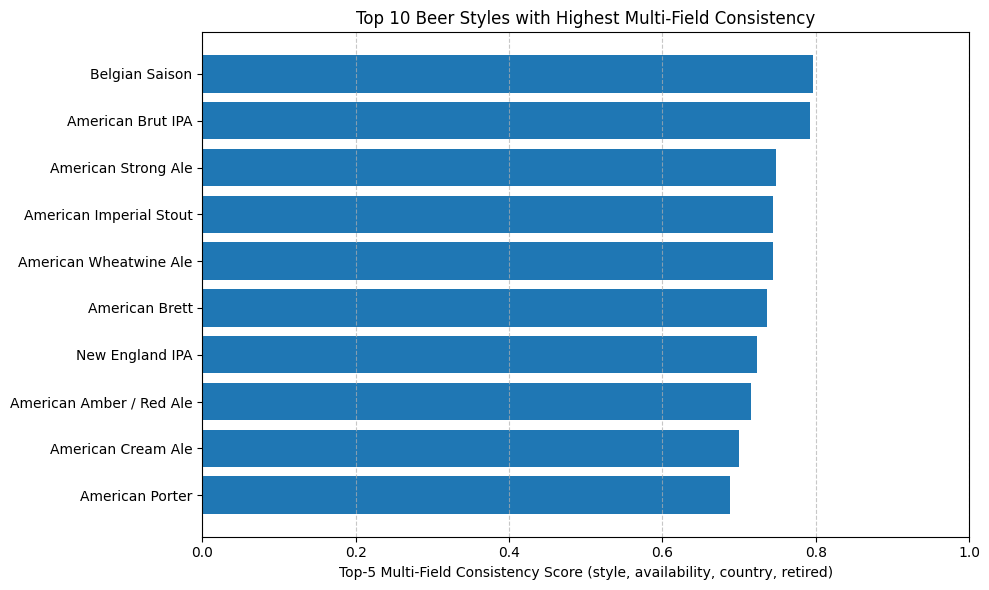

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Consistency evaluation function by style, checking multiple fields
def multi_field_consistency_by_style(beer_vectors, beers_df, top_n=5, fields=['style', 'availability', 'country', 'retired']):
    similarity_matrix = cosine_similarity(beer_vectors)
    np.fill_diagonal(similarity_matrix, -1)

    style_scores = {}

    for style in beers_df['style'].unique():
        style_indices = beers_df[beers_df['style'] == style].index
        if len(style_indices) < 2:
            continue

        total, correct = 0, 0
        for idx in style_indices:
            top_indices = similarity_matrix[idx].argsort()[-top_n:]
            ref_row = beers_df.iloc[idx]
            recommended_rows = beers_df.iloc[top_indices]

            match = np.ones(len(recommended_rows), dtype=bool)
            for field in fields:
                match &= recommended_rows[field].values == ref_row[field]

            correct += sum(match)
            total += top_n

        style_scores[style] = correct / total if total > 0 else 0.0

    return style_scores

# Run the consistency check
fields = ['style', 'availability', 'country', 'retired']
style_consistency_scores = multi_field_consistency_by_style(beer_vectors, beers_df, top_n=5, fields=fields)

# Get top 10 beer styles by consistency score
top_styles_10 = dict(sorted(style_consistency_scores.items(), key=lambda item: item[1], reverse=True)[:10])


plt.figure(figsize=(10, 6))
plt.barh(list(top_styles_10.keys())[::-1], list(top_styles_10.values())[::-1])
plt.xlabel(f"Top-5 Multi-Field Consistency Score ({', '.join(fields)})")
plt.title("Top 10 Beer Styles with Highest Multi-Field Consistency")
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [40]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from tqdm import tqdm

df = pd.read_csv('D:/Master/FSS_25/Web_Mining/Project/reviews_stratified_sampled.csv')
df



,beer_id,username,date,text,look,smell,taste,feel,overall,score,has_look,has_smell,has_taste,has_feel,mentioned_aspects,sentiment
0,1428,Aethien,2012-02-12,"poured into a tulip, it looks a nice golden...",3.00,1.5,1.5,2.0,2.0,1.74,True,True,True,True,"look, smell, taste, feel",negative
1,4351,kojevergas,2011-07-31,can served into norrebro bryghus stemware i...,2.50,2.0,2.0,1.5,2.0,1.98,True,True,True,True,"look, smell, taste, feel",negative
2,70485,CMUbrew,2012-03-10,reviewed from notes 500ml can poured into a...,3.00,1.0,1.0,1.5,1.0,1.17,True,True,True,True,"look, smell, taste, feel",negative
3,27069,maximum12,2010-05-12,rec'd a bottle of this unbidden in a recent...,2.50,2.0,2.0,2.0,1.0,1.83,True,True,True,True,"look, smell, taste, feel",negative
4,44788,HarleyRider,2010-06-26,heading out on the boat my wife brings home...,3.00,1.0,1.0,3.0,2.0,1.52,True,True,True,True,"look, smell, taste, feel",negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27697,90141,BlackBelt5112203,2013-07-26,5 oz pour into a tasting glass on tap at th...,4.25,4.5,4.5,4.0,4.5,4.44,True,True,True,True,"look, smell, taste, feel",positive
27698,2128,woodychandler,2011-08-08,an afternoon of aus beers continued at my a...,4.00,4.0,4.0,4.0,4.0,4.00,True,True,True,True,"look, smell, taste, feel",positive
27699,19216,05Harley,2011-02-25,bottled on: (should be on the bottom right ...,5.00,4.0,4.0,4.0,4.0,4.06,True,True,True,True,"look, smell, taste, feel",positive
27700,41951,brewdlyhooked13,2008-07-19,appearance - pours a dark reddish caramel w...,4.00,4.0,4.0,4.5,5.0,4.25,True,True,True,True,"look, smell, taste, feel",positive


In [41]:
df = df[['beer_id', 'username', 'text', 'score']]

print(df.shape)       

df.info()             

df

(27702, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27702 entries, 0 to 27701
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   beer_id   27702 non-null  int64  
 1   username  27692 non-null  object 
 2   text      27702 non-null  object 
 3   score     27702 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 865.8+ KB


,beer_id,username,text,score
0,1428,Aethien,"poured into a tulip, it looks a nice golden...",1.74
1,4351,kojevergas,can served into norrebro bryghus stemware i...,1.98
2,70485,CMUbrew,reviewed from notes 500ml can poured into a...,1.17
3,27069,maximum12,rec'd a bottle of this unbidden in a recent...,1.83
4,44788,HarleyRider,heading out on the boat my wife brings home...,1.52
...,...,...,...,...
27697,90141,BlackBelt5112203,5 oz pour into a tasting glass on tap at th...,4.44
27698,2128,woodychandler,an afternoon of aus beers continued at my a...,4.00
27699,19216,05Harley,bottled on: (should be on the bottom right ...,4.06
27700,41951,brewdlyhooked13,appearance - pours a dark reddish caramel w...,4.25


# Training

In [51]:
user_counts = df_merged['username'].value_counts()
valid_users = user_counts[user_counts >= 2].index

df_clean = df_merged[
    df_merged['username'].isin(valid_users)
].dropna(subset=['username', 'text', 'beer_id', 'overall'])


final_user_counts = df_clean['username'].value_counts()
final_valid_users = final_user_counts[final_user_counts >= 2].index
df_clean = df_clean[df_clean['username'].isin(final_valid_users)]

print("Number of users that still appear only once:", (df_clean['username'].value_counts() < 2).sum())

Number of users that still appear only once: 0


In [52]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df_clean,
    test_size=0.2,
    random_state=42,
    stratify=df_clean['username']
)

In [53]:

# Load review data
reviews_df = pd.read_csv('D:/Master/FSS_25/Web_Mining/Project/reviews_stratified_sampled.csv')

# Merge with beers_df using beer_id
reviews_df['beer_id'] = reviews_df['beer_id'].astype(int)
beers_df['id'] = beers_df['id'].astype(int)

df_merged = pd.merge(reviews_df, beers_df, left_on='beer_id', right_on='id', how='left')
df_merged.dropna(subset=['text'], inplace=True)

df_merged[['beer_id', 'style', 'abv']].dropna().head()


,beer_id,style,abv
0,1428,European Strong Lager,11.6
34,2825,American Adjunct Lager,5.0
60,99878,American Imperial Porter,9.6
74,51007,American Wheatwine Ale,11.8
100,62185,Belgian Fruit Lambic,4.0


In [54]:

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_merged['text'])

valid_rows = df_merged[df_merged['style'].notna() & df_merged['abv'].notna()]
valid_indices = valid_rows.index
valid_tfidf_matrix = tfidf_matrix[valid_indices]


In [55]:

import numpy as np

user_profiles = {}
for user in df_merged['username'].unique():
    user_reviews = df_merged[(df_merged['username'] == user) & (df_merged['overall'] >= 3)]
    if not user_reviews.empty:
        user_vec = np.asarray(tfidf.transform(user_reviews['text']).mean(axis=0)).reshape(1, -1)
        user_profiles[user] = user_vec


In [56]:

from sklearn.metrics.pairwise import cosine_similarity

def recommend_beers_for_user(username, top_k=5):
    if username not in user_profiles:
        return f"User '{username}' has no sufficient review history."

    user_vec = user_profiles[username]
    sim_scores = cosine_similarity(user_vec, valid_tfidf_matrix).flatten()
    top_indices = sim_scores.argsort()[-top_k:][::-1]

    top_beers = df_merged.iloc[valid_indices[top_indices]]

    return top_beers[['beer_id', 'username', 'country', 'availability', 'username', 'text', 'overall', 'style', 'abv']]

# Example usage
recommend_beers_for_user('maximum12')


,beer_id,username,country,availability,username,text,overall,style,abv
24434,53872,chumba526,US,Limited (brewed once),chumba526,"this beer appears black, black as night. it...",4.00,American Strong Ale,12.0
26222,55317,Gueuzedude,US,Rotating,Gueuzedude,a solid pour into my 25cl tulip glass produ...,4.00,German Maibock,6.4
17258,42541,mikesgroove,US,Limited (brewed once),mikesgroove,this is a separate beer from the old one th...,3.50,Finnish Sahti,10.0
25666,276369,GreesyFizeek,US,Limited (brewed once),GreesyFizeek,"0% this one pours a pretty dark black, with...",4.25,American Imperial Stout,14.7
25710,55317,DelMontiac,US,Rotating,DelMontiac,poured from a brown 22oz bottle into a roug...,4.00,German Maibock,6.4



## 📊 Model Evaluation: Content-Based Filtering

To evaluate the performance of our content-based beer recommendation system, we implement two commonly used evaluation methods:

### ✅ 1. Hit@K (Top-K Accuracy)
- Measures whether the recommended Top-K beers include any beer that the user actually liked (appeared in their test set).
- A simple and intuitive metric.

### ✅ 2. Precision@K
- Measures how many of the Top-K recommended beers were actually liked by the user (i.e., appeared in their test set).
- Gives insight into the quality of recommendations.

We will also visualize:

📈 A plot showing **Hit@K** and **Precision@K** across multiple K values  
📈 A bar chart comparing user-level hit rates


In [57]:

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from collections import defaultdict

def evaluate_hit_and_precision_at_k(train_df, test_df, tfidf, tfidf_matrix_all, df_all, valid_indices, k_list=[1, 3, 5, 10]):
    hit_at_k = defaultdict(int)
    precision_at_k = defaultdict(float)
    total_users = 0

    users = set(train_df['username']).intersection(test_df['username'])

    for user in users:
        train_reviews = train_df[(train_df['username'] == user) & (train_df['overall'] >= 3)]
        test_reviews = test_df[test_df['username'] == user]

        if train_reviews.empty or test_reviews.empty:
            continue

        user_vec = tfidf.transform(train_reviews['text']).mean(axis=0)
        user_vec = np.asarray(user_vec).reshape(1, -1)

        sim_scores = cosine_similarity(user_vec, tfidf_matrix_all).flatten()
        top_indices = sim_scores.argsort()[::-1]
        top_beers = df_all.iloc[valid_indices[top_indices]]['beer_id'].values

        test_beers = set(test_reviews['beer_id'].values)

        for k in k_list:
            recommended_k = set(top_beers[:k])
            hits = recommended_k.intersection(test_beers)
            if hits:
                hit_at_k[k] += 1
            precision_at_k[k] += len(hits) / k

        total_users += 1

    hit_at_k = {k: hit_at_k[k] / total_users for k in k_list}
    precision_at_k = {k: precision_at_k[k] / total_users for k in k_list}

    print("Hit@K:", hit_at_k)
    print("Precision@K:", precision_at_k)
    return hit_at_k, precision_at_k


In [58]:

import matplotlib.pyplot as plt

def plot_hit_and_precision(hit_dict, precision_dict):
    ks = list(hit_dict.keys())
    hit_vals = [hit_dict[k] for k in ks]
    prec_vals = [precision_dict[k] for k in ks]

    plt.figure(figsize=(10, 5))
    plt.plot(ks, hit_vals, marker='o', label='Hit@K')
    plt.plot(ks, prec_vals, marker='s', label='Precision@K')
    plt.title('Evaluation Metrics vs K')
    plt.xlabel('K')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()


In [59]:

def user_level_hit_plot(train_df, test_df, tfidf, tfidf_matrix_all, df_all, valid_indices, K=5):
    user_hits = {}
    users = set(train_df['username']).intersection(test_df['username'])

    for user in users:
        train_reviews = train_df[(train_df['username'] == user) & (train_df['overall'] >= 3)]
        test_reviews = test_df[test_df['username'] == user]

        if train_reviews.empty or test_reviews.empty:
            continue

        user_vec = tfidf.transform(train_reviews['text']).mean(axis=0)
        user_vec = np.asarray(user_vec).reshape(1, -1)

        sim_scores = cosine_similarity(user_vec, tfidf_matrix_all).flatten()
        top_k_indices = sim_scores.argsort()[-K:][::-1]
        top_k_beers = df_all.iloc[valid_indices[top_k_indices]]['beer_id'].values

        hit = int(any(beer in top_k_beers for beer in test_reviews['beer_id'].values))
        user_hits[user] = hit

    # Plot bar chart
    users = list(user_hits.keys())[:20]
    scores = [user_hits[u] for u in users]

    plt.figure(figsize=(12, 5))
    plt.bar(users, scores, color='skyblue')
    plt.title(f'User-level Hit@{K} for First 20 Users')
    plt.xlabel('User')
    plt.ylabel(f'Hit@{K}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Hit@K: {1: 0.013612565445026177, 3: 0.026701570680628273, 5: 0.032460732984293195, 10: 0.03769633507853403}
Precision@K: {1: 0.013612565445026177, 3: 0.009598603839441534, 5: 0.007015706806282714, 10: 0.004031413612565439}


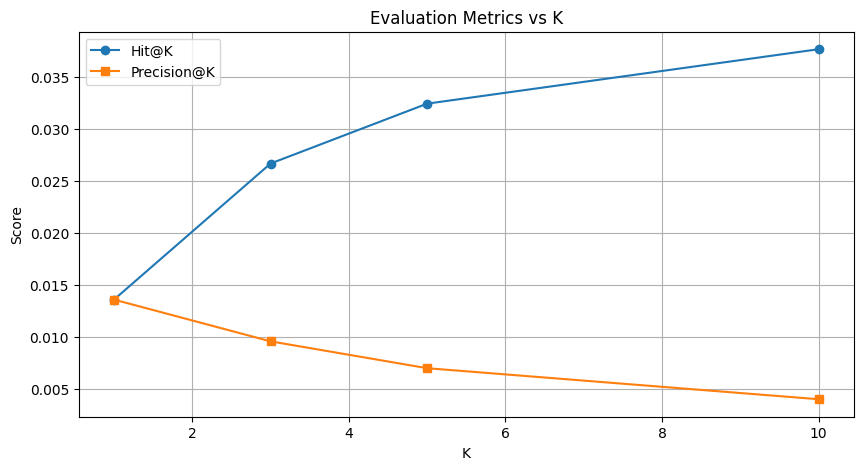

In [60]:

# Run evaluation
hit_k, prec_k = evaluate_hit_and_precision_at_k(
    train_df, test_df,
    tfidf, valid_tfidf_matrix,
    df_merged, valid_indices
)

# Plot results
plot_hit_and_precision(hit_k, prec_k)
